# **Load & Check VOICED data**

In [1]:
### import modules
'''for data management'''
#from google.colab import drive              # only for Colab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal 
from scipy.signal import welch, find_peaks            
import sklearn as sk
import random
from IPython.display import Audio
from scipy.spatial.distance import pdist, squareform                            
import sklearn.metrics.pairwise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

'''for model'''
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz
import torch
import torch.nn as nn

'''for evaluation'''
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
'''
The dataset can be download from:
https://physionet.org/content/voiced/1.0.0/
https://drive.google.com/file/d/1mSCWn5FiE0M0zz11u68cVORIqp0rMcP7/view?usp=sharing
'''

In [14]:
### set the path
'''mount google drive if dataset is in Google Drive'''
#drive.mount('/content/gdrive')

'''set the folder path'''
folder_path = '/content/gdrive/MyDrive/Σ.Fractisch/Colab/Data/VOICED'

'''get the list of file name'''
indx_list = ['00'+str(i) for i in range(1, 10)] +\
            ['0'+str(i) for i in range(10, 100)] +\
            [str(i) for i in range(100, 209)]
info_list = ['voice'+indx+'-info.txt' for indx in indx_list]  
voic_list = ['voice'+indx+'.txt' for indx in indx_list]
sample_no = len(indx_list)

print(info_list[:5])
print(voic_list[:5])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['voice001-info.txt', 'voice002-info.txt', 'voice003-info.txt', 'voice004-info.txt', 'voice005-info.txt']
['voice001.txt', 'voice002.txt', 'voice003.txt', 'voice004.txt', 'voice005.txt']


In [3]:
### read info data (.txt)
'''function for loading a info file'''
def read_VOICED_info(index):
    '''
    index = the index of target file --- integer
    '''
    info_load = open(folder_path+'/'+info_list[index] , 'r') 
    info_sample_txt = info_load.read()
    '''replace the empty row -> correct "1,5" to "1.5" -> add ":" after "ID" -> 
    add ":" after "a day" -> get rid of "\t" and "\nEating habits:" '''
    info_sample_txt = info_sample_txt.replace('\n\t', '') \
                                     .replace(',', '.') \
                                     .replace('ID', 'ID:') \
                                     .replace('a day', 'a day:') \
                                     .replace(' gr', '') \
                                     .replace('\nEating habits:', '') \
                                     .replace('\t','')
    info_load.close()
    return info_sample_txt

'''check an info data'''
index = 0
print(read_VOICED_info(index))

'''read all info files and integrate to dataframe'''
info = pd.DataFrame()
for i in range(sample_no):
    info_sample_txt = read_VOICED_info(i).replace('\n', ':').split(':')
    info_sample_df = pd.DataFrame([info_sample_txt[x] for x in range(1, len(info_sample_txt)-1, 2)],
                                  index=[info_sample_txt[x] for x in range(0, len(info_sample_txt)-1, 2)],
                                  columns=[i])
    info = pd.concat([info, info_sample_df], axis=1)

info = info.T
info.columns=['ID', 'Age', 'Gender', 'Diagnosis', 'Occupation', 'VHI', 'RSI', 
              'Smoker', 'Cigarettes (#/day)', 'Alcohol', 'Alcohol (glasses/day)', 
              'Water (L/day)', 'Carbonated', 'Carbonated (glasses/day)', 
              'Tomatoes', 'Coffee', 'Coffee (cups/day)', 'Chocolate', 'Chocolate (gm/day)', 
              'Cheese', 'Cheese (gm/day)' , 'Citrus fruits', 'Fruits (#/day)']

'''unify the diagnosis terms'''
info['Diagnosis'][info['Diagnosis'].str.contains('healthy')] = 'healthy'
info['Diagnosis'][info['Diagnosis'].str.contains('hyperkinetic')] = 'hyperkinetic'
info['Diagnosis'][info['Diagnosis'].str.contains('hypokinetic')] = 'hypokinetic'
info['Diagnosis'][info['Diagnosis'].str.contains('reflux')] = 'reflux'

display(info)

ID:voice001
Age:32
Gender:m
Diagnosis:hyperkinetic dysphonia
Occupation status:Researcher
Voice Handicap Index (VHI) Score:15
Reflux Symptom Index (RSI) Score:5
Smoker:no
Number of cigarettes smoked per day:NU
Alcohol consumption:casual drinker
Number of glasses containing alcoholic beverage drinked in a day:NU
Amount of water's litres drink every day:1.5
Carbonated beverages:almost never
Amount of glasses drinked in a day:NU
Tomatoes:sometimes
Coffee:almost always
Number of cups of coffee drinked in a day:4
Chocolate:almost never
Gramme of chocolate eaten in  a day:NU
Soft cheese:sometimes
Gramme of soft cheese eaten in a day:NU
Citrus fruits:sometimes
Number of citrus fruits eaten in a day:NU



,ID,Age,Gender,Diagnosis,Occupation,VHI,RSI,Smoker,Cigarettes (#/day),Alcohol,Alcohol (glasses/day),Water (L/day),Carbonated,Carbonated (glasses/day),Tomatoes,Coffee,Coffee (cups/day),Chocolate,Chocolate (gm/day),Cheese,Cheese (gm/day),Citrus fruits,Fruits (#/day)
0,voice001,32,m,hyperkinetic,Researcher,15,5,no,NU,casual drinker,NU,1.5,almost never,NU,sometimes,almost always,4,almost never,NU,sometimes,NU,sometimes,NU
1,voice002,55,m,healthy,Employee,17,12,casual smoker,2,habitual drinker,1,0.5,almost always,3,sometimes,sometimes,3,sometimes,NU,almost always,50,almost always,2
2,voice003,34,m,hyperkinetic,Researcher,42,26,no,NU,casual drinker,1,1.5,sometimes,1,sometimes,almost always,NU,sometimes,20,almost always,200,almost never,NU
3,voice004,28,f,hypokinetic,Researcher,20,9,casual smoker,NU,casual drinker,NU,1,almost never,NU,sometimes,always,3,sometimes,NU,almost always,NU,sometimes,NU
4,voice005,54,f,hypokinetic,Researcher,39,23,no,NU,casual drinker,NU,1.5,never,NU,sometimes,never,NU,sometimes,150,sometimes,200,almost always,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,voice204,59,f,healthy,Singer,0,7,no,NU,nondrinker,NU,2,sometimes,NU,sometimes,sometimes,NU,sometimes,NU,almost never,NU,almost never,NU
204,voice205,30,f,hyperkinetic,Hairstylist,62,19,yes,15,casual drinker,NU,1,almost never,NU,sometimes,always,3,almost always,NU,sometimes,NU,sometimes,NU
205,voice206,22,f,healthy,Singer,0,6,no,NU,nondrinker,NU,2.5,almost never,NU,sometimes,sometimes,NU,sometimes,NU,sometimes,NU,almost never,NU
206,voice207,30,f,healthy,Singer,0,26,no,NU,nondrinker,NU,2,never,NU,sometimes,never,NU,sometimes,NU,sometimes,NU,sometimes,NU


diag.shape = (208,) <class 'numpy.ndarray'>


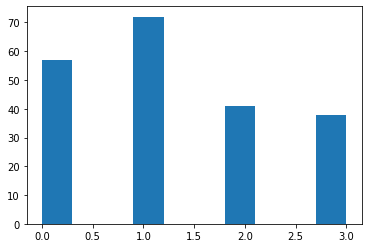

In [4]:
### extract the diagnosis to be the labels
diag = info['Diagnosis'].values
diag[diag=='healthy'] = 0
diag[diag=='hyperkinetic'] = 1
diag[diag=='hypokinetic'] = 2
diag[diag=='reflux'] = 3

print('diag.shape =', diag.shape, type(diag))
plt.hist(diag); plt.show()

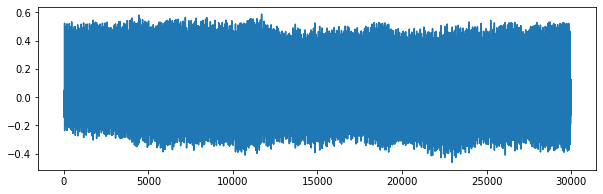

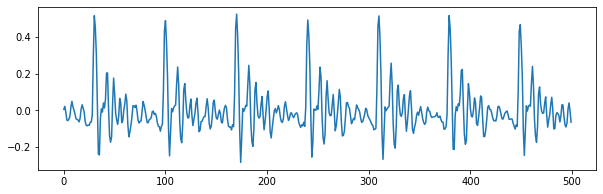

In [5]:
### load voice data (.txt)
'''function for reading signal files'''
def read_VOICED_signal(index, start=5000, end=35000):
    '''
    index = the index of target file --- integer
    start = the start point of reading the signal --- integer
    end = the end point of reading the signal --- integer
    '''
    voic_load = open(folder_path+'/'+voic_list[index], 'r') 
    voic_sample = voic_load.read().split('\n')
    voic_sample = [float(voic_sample[i]) for i in range(0, len(voic_sample)-1)]    # the last element is "" will make float() error
    voic_sample = voic_sample[start:end]
    voic_load.close()
    return np.array(voic_sample)

'''check a voice recording'''
index=0

plt.figure(figsize=(10, 3))
plt.plot(read_VOICED_signal(index))
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(read_VOICED_signal(index)[1000:1500])
plt.show()

'''read all voice recording'''
voic = np.zeros((sample_no, 30000))
for i in range(sample_no):
    voic[i] = read_VOICED_signal(i)


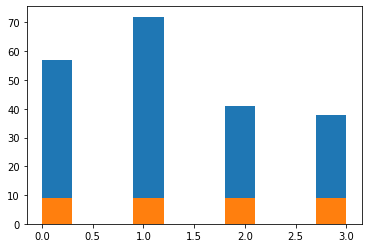

train_voic.shape = (172, 30000) <class 'numpy.ndarray'>
test_voic.shape = (36, 30000) <class 'numpy.ndarray'>


In [6]:
### spliting data into training and testing set
'''function for spliting a subset by randomly choosing samples with balanced classes'''
def equal_shuffle_sample(data, labels, n_subjects):
    '''
    data = dataset to be split
    labels = labels to be split
    n_subjects = the numbers of each class---integer
    '''
    plt.hist(labels) 
    n_classes = len(set(labels))

    '''get the class_1 samples'''
    other_data = data[np.where(labels==0)]
    other_labels = labels[np.where(labels==0)]
    '''randomly choose [n_subjects] samples of class_1'''
    other_data, equal_data, other_labels, equal_labels = train_test_split(other_data, other_labels, test_size=n_subjects, random_state=42)

    '''repeat the same step for other classes'''
    for i in range(1, n_classes):
        class_data = data[np.where(labels==i)]
        class_labels = labels[np.where(labels==i)]
        class_data, split_data, class_labels, split_labels= train_test_split(class_data, class_labels, test_size=n_subjects, random_state=53)

        other_data = np.concatenate((other_data, class_data), axis=0)
        equal_data = np.concatenate((equal_data, split_data), axis=0)
        other_labels = np.concatenate((other_labels, class_labels), axis=0)
        equal_labels = np.concatenate((equal_labels, split_labels), axis=0)
        
    plt.hist(equal_labels); plt.show()
    return other_data, equal_data, other_labels, equal_labels

'''split the test dataset with a total 36 subjects (9 subjects for each class)'''
train_voic, test_voic, train_diag, test_diag = equal_shuffle_sample(voic, diag, n_subjects=9)
print('train_voic.shape =', train_voic.shape, type(train_voic))
print('test_voic.shape =', test_voic.shape, type(test_voic))

In [7]:
### play the voice
Audio(train_voic[0], rate=8000)

In [8]:
### downsampling (sampling rate 8000 Hz -> 4000 Hz)
'''function for down-sampling and obtaining two 4000-Hz signal'''
def halfsample(voic, diag):
    voic_halfsample_A = []
    voic_halfsample_B = []
    for i in range(len(voic)):
        voic_halfsample_A.append(voic[i][0::2])
        voic_halfsample_B.append(voic[i][1::2])
    voic_halfsample = np.array(voic_halfsample_A + voic_halfsample_B)
    diag_halfsample = np.concatenate((diag, diag))
    return voic_halfsample, diag_halfsample

'''down-sampling all samples'''
train_data, train_labels = halfsample(train_voic, train_diag)
test_data, test_labels = halfsample(test_voic, test_diag)
print('train_data.shape =', train_data.shape, type(train_data))
print('test_data.shape =', test_data.shape, type(test_data))

'''check the voice again'''
Audio(train_data[0], rate=4000)

train_data.shape = (344, 15000) <class 'numpy.ndarray'>
test_data.shape = (72, 15000) <class 'numpy.ndarray'>


In [9]:
### divide signal into segments
'''function for divide signal into segments'''
def divide_signal(data, labels, window=100, moving=100, divide=120, mode='simple', RP_scale=1000, RP_ceil=100):
    '''
    data = the signal dataset to be processed
    labels = the labels of the signal dataset
    window = the length of each segment --- integer
    moving = the distance between the start point of segments --- integer
    divide = the number of total segments from 1 signal --- integer
    mode = 'simple' is used for machine learning here, each segment will be output as a vector
           'CNN1d' is used for 1-D convolution, each segment will be output with a shape of (1, window)
           'RecuPlot' is used for generating recurrence plot and 2-D convolution, each segment will be output with a shape of (1, window, window)
    RP_scale = the scaling factor of recurrence plot, only used in 'RecuPlot' mode --- positive number
    RP_ceil = the upper limit of recurrence plot, only used in 'RecuPlot' mode --- positive number
    '''
    sample_no = len(labels)
    c = 0

    if mode == 'simple':
        x = np.zeros((sample_no*divide, window))
        y = np.zeros(sample_no*divide)
        for n in range(sample_no): 
            sample = data[n]
            for s in range(divide):
                x[c,:]  =  np.array(sample[s*moving : s*moving+window])
                y[c] = labels[n]
                c += 1            

    elif mode == 'CNN1d':
        x = np.zeros((sample_no*divide, 1, window))
        y = np.zeros(sample_no*divide)
        for n in range(sample_no):                                   
            sample = data[n]
            for s in range(divide):
                x[c,0,:]  =  np.array(sample[s*moving : s*moving+window])
                y[c] = labels[n]
                c += 1

    elif mode == 'RecuPlot':         
        x = np.zeros((sample_no*divide, 1, window, window))
        y = np.zeros(sample_no*divide)
        for n in range(sample_no): 
            sample = data[n]
            for s in range(divide):
                segment  = np.array(sample[s*moving : s*moving+window])
                x[c,0,:,:]  =  RecuPlot(segment.reshape(-1, 1), RP_scale=RP_scale, RP_ceil=RP_ceil)
                y[c] = labels[n]
                c += 1
    return x, y

'''function for generating recurrence plot''' 
def RecuPlot(signal, RP_scale=1000, RP_ceil=100):
    '''
    RP_scale = the scaling factor of recurrence plot, only used in 'RecuPlot' mode --- positive number
    RP_ceil = the upper limit of recurrence plot, only used in 'RecuPlot' mode --- positive number
    '''
    RP = sk.metrics.pairwise.pairwise_distances(signal)                           
    RP = np.floor(RP*RP_scale)                                                      
    RP[RP > RP_ceil] = RP_ceil                                    
    return RP


# **SVM**

### **Data pre-processing**

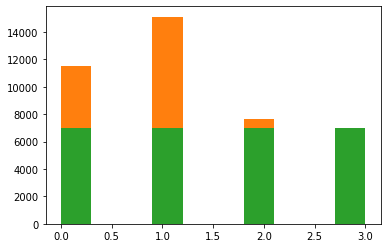

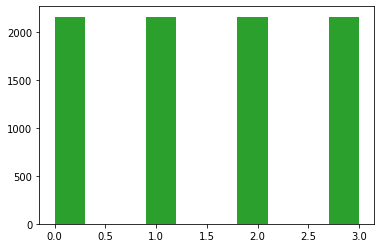

x_train.shape = (26722, 100) <class 'numpy.ndarray'>
x_valid.shape = (1114, 100) <class 'numpy.ndarray'>
x_test.shape = (1296, 100) <class 'numpy.ndarray'>


In [13]:
### divide data into segments
'''split each voice recording into segments'''
x_train, y_train = divide_signal(train_data, train_labels, window=100, moving=100, divide=120, mode='simple')
x_test, y_test = divide_signal(test_data, test_labels, window=100, moving=100, divide=120, mode='simple')

'''balance the number of each class in datasets'''
_, x_train, _, y_train = equal_shuffle_sample(x_train, y_train, n_subjects=int(np.sort(plt.hist(y_train)[0])[-len(set(y_train))])-1)
_, x_test, _, y_test = equal_shuffle_sample(x_test, y_test, n_subjects=int(np.sort(plt.hist(y_test)[0])[-len(set(y_test))])-1)

'''spliting traing data into training and validation set'''
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train, 
                                                      test_size=0.04,
                                                      random_state=56)

'''randomly choose about 1000 segemnts for testing'''
_, x_test, _, y_test = train_test_split(x_test,
                                        y_test, 
                                        test_size=0.15,
                                        random_state=37)

print('x_train.shape =', x_train.shape, type(x_train))
print('x_valid.shape =', x_valid.shape, type(x_valid))
print('x_test.shape =', x_test.shape, type(x_test))

peak frequency :  [ 840. 1040.  640. 1480.  440.]
PSD value of peak frequency :  [5.63380818e-04 1.85649799e-04 9.08018076e-05 7.60960436e-05
 6.39366690e-05]


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


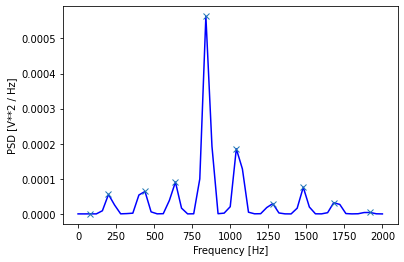

In [14]:
### function for power spectral density
def get_psd_values(signal, f=4000):
    f_values, psd_values = welch(signal, fs=f)
    peaks, _ = find_peaks(psd_values)              # get peak index
    ranked_peak = peaks[np.argsort(psd_values[peaks])][::-1]
    return f_values, psd_values, ranked_peak

'''check PSD for a sample'''
f_values, psd_values, ranked_peak = get_psd_values(x_train[1], f=4000)
print('top 5 peak frequency : ', f_values[ranked_peak[:5]])
print('PSD value of peak frequency : ', psd_values[ranked_peak[:5]])
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.plot(f_values[ranked_peak], psd_values[ranked_peak], "x")
plt.show()

top 5 peak time-lag :  [0.00475 0.0095  0.00125 0.01425 0.0035 ]
AC value of peak time-lag :  [5.32187011 3.85212201 2.58610981 2.41227848 2.37058924]


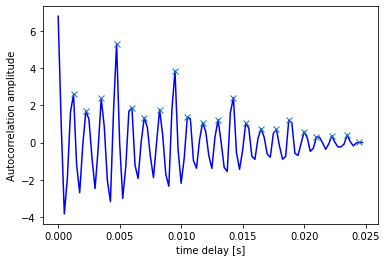

In [15]:
### function for autocorrelation
def autocorr(signal):
    result = np.correlate(signal, signal, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(signal, f=4000):
    '''
    f = sampling rate of signal
    '''
    N = len(signal)
    T = 1/f
    t_values = np.array([T * jj for jj in range(0, N)])
    ac_values = autocorr(signal)

    peaks, _ = find_peaks(ac_values)              # get peak index
    ranked_peak = peaks[np.argsort(ac_values[peaks])][::-1]
    return t_values, ac_values, ranked_peak

'''check AC for a sample'''
t_values, ac_values, ranked_peak = get_autocorr_values(x_train[1], 4000)
plt.plot(t_values, ac_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
print('top 5 peak time-lag : ', t_values[ranked_peak[:5]])
print('AC value of peak time-lag : ', ac_values[ranked_peak[:5]])
plt.plot(t_values[ranked_peak], ac_values[ranked_peak], "x")
plt.show()

In [17]:
### function for getting both PSD (top five peak and its value) and AC features (top peak and its value)
def get_features(signal, f=4000):
    features = []
    f_values, psd_values, psd_ranked_peak = get_psd_values(signal, f)
    t_values, ac_values, ac_ranked_peak = get_autocorr_values(signal, f)
    features = np.concatenate((f_values[psd_ranked_peak[:5]], 
                               psd_values[psd_ranked_peak[:5]],
                               t_values[ac_ranked_peak[:1]],
                               ac_values[ac_ranked_peak[:1]]))
    return features

'''get the features of each sample and normalization'''
x_train_features = np.zeros((len(x_train), 12))
x_valid_features = np.zeros((len(x_valid), 12))
x_test_features = np.zeros((len(x_test), 12))

col_names = ['f1', 'f2', 'f3', 'f4', 'f5', 
             'psd1', 'psd2', 'psd3', 'psd4', 'psd5', 
             't1', 'ac1']

for i in range(len(x_train)):
    x_train_features[i] = get_features(x_train[i])
x_train_features = pd.DataFrame(x_train_features, columns=col_names)
x_train_norm = (x_train_features-x_train_features.min()) / (x_train_features.max()-x_train_features.min())
display(x_train_norm)

for i in range(len(x_valid)):
    x_valid_features[i] = get_features(x_valid[i])
x_valid_features = pd.DataFrame(x_valid_features, columns=col_names)
x_valid_norm = (x_valid_features-x_train_features.min()) / (x_train_features.max()-x_train_features.min())
display(x_valid_norm)

for i in range(len(x_test)):
    x_test_features[i] = get_features(x_test[i])
x_test_features = pd.DataFrame(x_test_features, columns=col_names)
x_test_norm = (x_test_features-x_train_features.min()) / (x_train_features.max()-x_train_features.min())
display(x_test_norm)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


,f1,f2,f3,f4,f5,psd1,psd2,psd3,psd4,psd5,t1,ac1
0,0.446809,0.625000,0.354167,0.520833,0.708333,0.048143,0.056730,0.072019,0.150772,0.178930,0.244186,0.076804
1,0.425532,0.520833,0.312500,0.750000,0.208333,0.109220,0.179819,0.148801,0.281725,0.323561,0.197674,0.192527
2,0.085106,0.166667,0.270833,0.645833,0.354167,0.057135,0.169408,0.194234,0.200759,0.234845,0.232558,0.126499
3,0.297872,0.375000,0.145833,0.062500,0.687500,0.100628,0.157374,0.161750,0.152299,0.144186,0.290698,0.130266
4,0.148936,0.458333,0.291667,0.916667,0.541667,0.096385,0.090876,0.102243,0.151292,0.034214,0.127907,0.165428
...,...,...,...,...,...,...,...,...,...,...,...,...
26717,0.382979,0.562500,0.312500,0.500000,0.437500,0.028500,0.076046,0.081270,0.172260,0.191861,0.348837,0.061928
26718,0.702128,0.333333,0.437500,0.604167,0.520833,0.085123,0.253688,0.336720,0.315753,0.345841,0.244186,0.176782
26719,0.297872,0.208333,0.145833,0.687500,0.062500,0.226339,0.294435,0.134036,0.257408,0.210871,0.290698,0.282840
26720,0.574468,0.104167,0.437500,0.208333,0.333333,0.102530,0.127759,0.146344,0.249650,0.297485,0.186047,0.160016


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


,f1,f2,f3,f4,f5,psd1,psd2,psd3,psd4,psd5,t1,ac1
0,0.063830,0.520833,0.333333,0.250000,0.437500,0.010477,0.007870,0.008857,0.019505,0.026558,0.244186,0.015250
1,0.744681,0.479167,0.291667,0.604167,0.979167,0.036440,0.151258,0.032952,0.066014,0.083919,0.069767,0.058785
2,0.382979,0.687500,0.291667,0.187500,0.479167,0.054181,0.077641,0.126150,0.159669,0.162917,0.220930,0.097631
3,0.340426,0.562500,0.208333,0.104167,0.437500,0.029333,0.057747,0.060886,0.122238,0.149510,0.186047,0.062985
4,0.638298,0.104167,0.500000,0.562500,0.729167,0.063345,0.270468,0.380433,0.588891,0.178962,0.162791,0.112889
...,...,...,...,...,...,...,...,...,...,...,...,...
1109,0.085106,0.437500,0.541667,0.312500,0.666667,0.089405,0.202294,0.116265,0.259905,0.343087,0.186047,0.181409
1110,0.361702,0.479167,0.875000,0.750000,0.625000,0.092512,0.383699,0.200873,0.384296,0.121764,0.162791,0.225416
1111,0.063830,0.312500,0.375000,0.229167,0.145833,0.089864,0.203905,0.255603,0.410642,0.493880,0.267442,0.178634
1112,0.361702,0.437500,0.645833,0.208333,0.583333,0.072642,0.162740,0.190580,0.325937,0.306470,0.302326,0.187263


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))


,f1,f2,f3,f4,f5,psd1,psd2,psd3,psd4,psd5,t1,ac1
0,0.510638,0.416667,0.062500,0.583333,0.229167,0.041994,0.067834,0.100847,0.135162,0.154856,0.255814,0.079192
1,0.319149,0.041667,0.250000,0.125000,0.583333,0.049181,0.185155,0.214694,0.224833,0.187192,0.337209,0.101785
2,0.085106,0.187500,0.291667,0.500000,0.708333,0.008580,0.004654,0.007306,0.013170,0.013143,0.209302,0.011164
3,0.468085,0.104167,0.583333,0.229167,0.333333,0.038959,0.076511,0.068581,0.116195,0.078772,0.174419,0.063164
4,0.574468,0.750000,0.354167,0.166667,0.937500,0.167899,0.365551,0.160975,0.232137,0.054303,0.104651,0.308427
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,0.468085,0.541667,0.250000,0.187500,0.375000,0.005887,0.021025,0.009895,0.015578,0.018502,0.023256,0.009362
1292,0.085106,0.604167,0.291667,0.354167,0.395833,0.024056,0.052444,0.055495,0.094968,0.105084,0.441860,0.058963
1293,0.085106,0.354167,0.458333,0.270833,0.166667,0.004850,0.017831,0.021372,0.020336,0.016419,0.232558,0.014298
1294,0.553191,0.312500,0.375000,0.583333,0.479167,0.059279,0.267048,0.392370,0.458710,0.149007,0.406977,0.099158


### **Model training**

accuracy of training dateset = 0.685614849187935
accuracy of validation dateset = 0.6768402154398564
accuracy of testing dateset = 0.30401234567901236
              precision    recall  f1-score   support

         0.0       0.26      0.31      0.28       325
         1.0       0.20      0.13      0.16       330
         2.0       0.43      0.42      0.43       324
         3.0       0.30      0.36      0.33       317

    accuracy                           0.30      1296
   macro avg       0.30      0.31      0.30      1296
weighted avg       0.30      0.30      0.30      1296



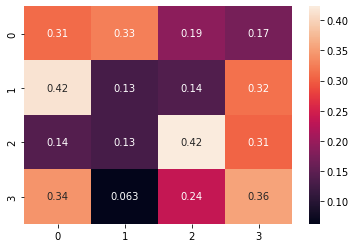

In [18]:
### SVM(rbf)
svm_model = SVC(kernel='rbf')

''' fit the model to the data'''
svm_model.fit(x_train_norm, y_train)
y_train_pred = svm_model.predict(x_train_norm)
print('accuracy of training dateset =', accuracy_score(y_train_pred, y_train))

y_valid_pred = svm_model.predict(x_valid_norm)
print('accuracy of validation dateset =', accuracy_score(y_valid_pred, y_valid))

y_test_pred = svm_model.predict(x_test_norm)
print('accuracy of testing dateset =', accuracy_score(y_test_pred, y_test))
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred, normalize= 'true')
df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
sns.heatmap(df_cm, annot=True); plt.show()


accuracy of training dateset = 0.6213232542474366
accuracy of validation dateset = 0.6140035906642729
accuracy of testing dateset = 0.2839506172839506
              precision    recall  f1-score   support

         0.0       0.25      0.36      0.30       325
         1.0       0.15      0.07      0.10       330
         2.0       0.39      0.37      0.38       324
         3.0       0.28      0.35      0.31       317

    accuracy                           0.28      1296
   macro avg       0.27      0.29      0.27      1296
weighted avg       0.27      0.28      0.27      1296



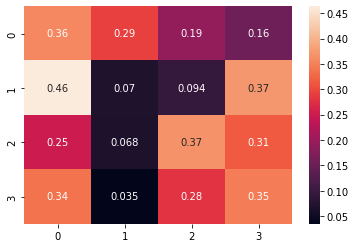

In [19]:
### SVM(poly, 3)
svm_model = SVC(kernel='poly', degree=3)

''' fit the model to the data'''
svm_model.fit(x_train_norm, y_train)
y_train_pred = svm_model.predict(x_train_norm)
print('accuracy of training dateset =', accuracy_score(y_train_pred, y_train))

y_valid_pred = svm_model.predict(x_valid_norm)
print('accuracy of validation dateset =', accuracy_score(y_valid_pred, y_valid))

y_test_pred = svm_model.predict(x_test_norm)
print('accuracy of testing dateset =', accuracy_score(y_test_pred, y_test))
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred, normalize= 'true')
df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
sns.heatmap(df_cm, annot=True); plt.show()


# **1D-DCNN**

### **Data pre-processing**

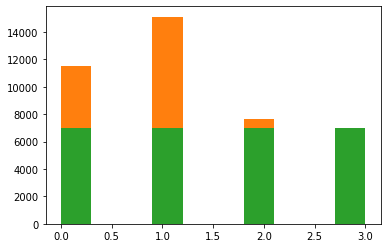

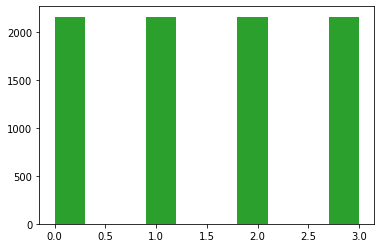

x_train.shape = (26722, 1, 100) <class 'numpy.ndarray'>
x_valid.shape = (1114, 1, 100) <class 'numpy.ndarray'>
x_test.shape = (1296, 1, 100) <class 'numpy.ndarray'>


In [31]:
# divide data into segments
x_train, y_train = divide_signal(train_data, train_labels, window=100, moving=100, divide=120, mode='CNN1d')
x_test, y_test = divide_signal(test_data, test_labels, window=100, moving=100, divide=120, mode='CNN1d')

'''balance the number of each class in datasets'''
_, x_train, _, y_train = equal_shuffle_sample(x_train, y_train, n_subjects=int(np.sort(plt.hist(y_train)[0])[-len(set(y_train))])-1)
_, x_test, _, y_test = equal_shuffle_sample(x_test, y_test, n_subjects=int(np.sort(plt.hist(y_test)[0])[-len(set(y_test))])-1)

'''spliting traing data into training and validation set'''
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train, 
                                                      test_size=0.04,
                                                      random_state=56)

'''randomly choos about 1000 segemnts for testing'''
_, x_test, _, y_test = train_test_split(x_test,
                                        y_test, 
                                        test_size=0.15,
                                        random_state=37)

print('x_train.shape =', x_train.shape, type(x_train))
print('x_valid.shape =', x_valid.shape, type(x_valid))
print('x_test.shape =', x_test.shape, type(x_test))

### **Model training**

In [23]:
class DCNN_1D:
    ''' 
        Inputs:        
        n_features - how many features does one sample of our data have (how many columns does the matrix have)
        hidden_dimension - the number of hidden neurons we want?
        n_classes - the number of unique labels in our data (i.e. 0,1 for the Breast Cancer dataset)
    '''
    def __init__(self, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
        self.train_data = train_data        
        self.train_labels = train_labels
        self.valid_data = valid_data
        self.valid_labels = valid_labels
        self.test_data = test_data        
        self.test_labels = test_labels

    class Net(nn.Module):
        def __init__(self, window, n_classes):
            super(DCNN_1D.Net, self).__init__()
            self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, dilation=3),
                                       nn.ReLU(),
                                       nn.MaxPool1d(kernel_size=2, stride=2),
                                       nn.Dropout(p=0.5))
            self.conv2 = nn.Sequential(nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, dilation=2),
                                       nn.ReLU(),
                                       nn.MaxPool1d(kernel_size=2, stride=2),
                                       nn.Dropout(p=0.5))
            
            self.fucon = nn.Sequential(nn.Linear(in_features=672, out_features=512), 
                                       nn.Linear(in_features=512, out_features=256),
                                       nn.Linear(in_features=256, out_features=128),
                                       nn.LeakyReLU(negative_slope=0.03),
                                       nn.Dropout(p=0.5))
            self.outpt = nn.Linear(128, n_classes)
            
        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)

            x = x.flatten(start_dim = 1)
            x = self.fucon(x)
            x = self.outpt(x)
            return nn.functional.softmax(x)

    def train_test(self, n_epochs, batch_size, lr, model=None):
        train_data_batches, train_label_batches = batchify(self.train_data, self.train_labels, batch_size=batch_size)

        if model == None:
            model = DCNN_1D.Net(window = 100, n_classes = 4)
        else:
            model = model


        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()
        
        for i in range(n_epochs):
            model.train()
            train_correct = 0
            for ii in range(len(train_data_batches)):
                optimizer.zero_grad()
                batch = train_data_batches[ii]
                labels = train_label_batches[ii]
                
                predictions = model(torch.tensor(batch.astype(np.float32)))
                loss = loss_function(predictions, torch.LongTensor(labels))

                loss.backward()
                optimizer.step() 

                for n, pred in enumerate(predictions.data):
                    if labels[n] == torch.argmax(pred):
                        train_correct += 1
            print("Epoch # " + str(i) + ": train_acc = " + str(round(train_correct/len(self.train_data), 4)), end=', ')

            model.eval()
            valid_correct = 0
            predictions = model(torch.tensor(self.valid_data.astype(np.float32)))
            for n, pred in enumerate(predictions.data):
                if self.valid_labels[n] == torch.argmax(pred):
                        valid_correct += 1
            print("valid_acc = " + str(round(valid_correct/len(self.valid_data), 4)), end=', ')
            
            test_correct = 0
            test_predict = np.zeros((len(self.test_data)))
            predictions = model(torch.tensor(self.test_data.astype(np.float32)))
            for n, pred in enumerate(predictions.data):
                if self.test_labels[n] == torch.argmax(pred):
                        test_correct += 1
                test_predict[n] = torch.argmax(pred)       
            print("test_acc = " + str(round(test_correct/len(self.test_data), 4)))
            
        print(classification_report(self.test_labels, test_predict))
        cm = confusion_matrix(self.test_labels, test_predict, normalize= 'true')
        df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
        sns.heatmap(df_cm, annot=True); plt.show()

        return model

def batchify(data,labels,batch_size=16):
    batches= []
    label_batches = []
    for n in range(0,len(data),batch_size):
        if n+batch_size < len(data):
            batches.append(data[n:n+batch_size])
            label_batches.append(labels[n:n+batch_size])
    if len(data)%batch_size > 0:
        batches.append(data[len(data)-(len(data)%batch_size):len(data)])
        label_batches.append(labels[len(data)-(len(data)%batch_size):len(data)])
    return batches,label_batches


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch # 0: train_acc = 0.278, valid_acc = 0.2917, test_acc = 0.2878
Epoch # 1: train_acc = 0.3434, valid_acc = 0.4147, test_acc = 0.3333
Epoch # 2: train_acc = 0.3907, valid_acc = 0.4084, test_acc = 0.3434
Epoch # 3: train_acc = 0.4112, valid_acc = 0.4596, test_acc = 0.3688
Epoch # 4: train_acc = 0.4255, valid_acc = 0.4659, test_acc = 0.3542
Epoch # 5: train_acc = 0.4453, valid_acc = 0.4811, test_acc = 0.3519
Epoch # 6: train_acc = 0.4566, valid_acc = 0.4829, test_acc = 0.3179
Epoch # 7: train_acc = 0.4674, valid_acc = 0.5018, test_acc = 0.2855
Epoch # 8: train_acc = 0.4788, valid_acc = 0.5009, test_acc = 0.3326
Epoch # 9: train_acc = 0.4775, valid_acc = 0.5287, test_acc = 0.3102
Epoch # 10: train_acc = 0.4907, valid_acc = 0.5045, test_acc = 0.2917
Epoch # 11: train_acc = 0.4952, valid_acc = 0.5224, test_acc = 0.3117
Epoch # 12: train_acc = 0.4964, valid_acc = 0.5395, test_acc = 0.2901
Epoch # 13: train_acc = 0.4993, valid_acc = 0.5368, test_acc = 0.304
Epoch # 14: train_acc = 0.5044, 

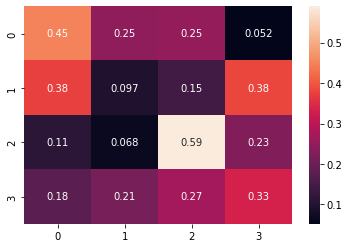

In [24]:
DCNN1 = DCNN_1D(x_train, y_train, x_valid, y_valid, x_test, y_test)
model = DCNN1.train_test(n_epochs=50, batch_size=300, lr=0.001)

# **AE+SVM**

### **Data pre-processing**

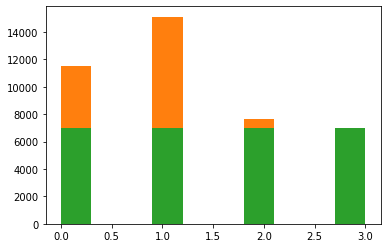

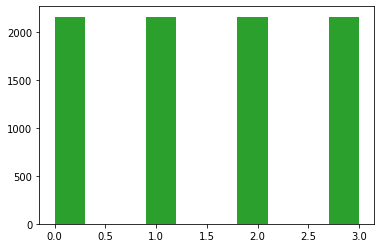

x_train.shape = (26722, 1, 100) <class 'numpy.ndarray'>
x_valid.shape = (1114, 1, 100) <class 'numpy.ndarray'>
x_test.shape = (1296, 1, 100) <class 'numpy.ndarray'>


In [ ]:
# divide data into segments
x_train, y_train = divide_signal(train_data, train_labels, window=100, moving=100, divide=120, mode='CNN1d')
x_test, y_test = divide_signal(test_data, test_labels, window=100, moving=100, divide=120, mode='CNN1d')

'''balance the number of each class in datasets'''
_, x_train, _, y_train = equal_shuffle_sample(x_train, y_train, n_subjects=int(np.sort(plt.hist(y_train)[0])[-len(set(y_train))])-1)
_, x_test, _, y_test = equal_shuffle_sample(x_test, y_test, n_subjects=int(np.sort(plt.hist(y_test)[0])[-len(set(y_test))])-1)

'''spliting traing data into training and validation set'''
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train, 
                                                      test_size=0.04,
                                                      random_state=56)

'''randomly choos about 1000 segemnts for testing'''
_, x_test, _, y_test = train_test_split(x_test,
                                        y_test, 
                                        test_size=0.15,
                                        random_state=37)

print('x_train.shape =', x_train.shape, type(x_train))
print('x_valid.shape =', x_valid.shape, type(x_valid))
print('x_test.shape =', x_test.shape, type(x_test))

### **Model training**

In [35]:
class AutoCNN:
    ''' 
        Inputs:        
        n_features - how many features does one sample of our data have (how many columns does the matrix have)
        hidden_dimension - the number of hidden neurons we want?
        n_classes - the number of unique labels in our data (i.e. 0,1 for the Breast Cancer dataset)
    '''
    def __init__(self, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
        self.train_data = train_data        
        self.train_labels = train_labels
        self.valid_data = valid_data
        self.valid_labels = valid_labels
        self.test_data = test_data        
        self.test_labels = test_labels    

    class Net(nn.Module):
        def __init__(self):
            super(AutoCNN.Net, self).__init__()

            self.conv1 = nn.Conv1d(1, 16, 3, dilation=3)
            self.conv2 = nn.Conv1d(16, 32, 3, dilation=2)
            
            self.pool = nn.MaxPool1d(kernel_size=2,return_indices=True)
            self.unpool = nn.MaxUnpool1d(2)

            self.tanh = nn.Tanh()
            self.relu = nn.ReLU()

            self.unconv2 = nn.ConvTranspose1d(32, 16, 3, dilation=2)            
            self.unconv1 = nn.ConvTranspose1d(16, 1, 3, dilation=3)
            
        def forward(self, x):
            x = self.conv1(x)
            x = self.relu(x)
            x, indices1 = self.pool(x)

            x = self.conv2(x)
            x = self.relu(x)
            x, indices2 = self.pool(x)

            f = x.flatten(start_dim = 1)
            
            x = self.unpool(x, indices2, output_size=(1,1,43))
            x = self.unconv2(x)
            x = self.relu(x)
          
            x = self.unpool(x, indices1, output_size=(1,1,94))
            x = self.unconv1(x)
            x = self.tanh(x)

        
            return x, f.detach().numpy()

    def train_test(self, n_epochs, batch_size, lr, model=None, show=None):
        train_data_batches = batchify(self.train_data, batch_size=batch_size)

        if model == None:
            model = AutoCNN.Net()
        else:
            model = model

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.MSELoss()
        
        for i in range(n_epochs):
            model.train()
            train_error = 0
            for ii in range(len(train_data_batches)):
                optimizer.zero_grad()
                batch = train_data_batches[ii]
                
                predictions, _ = model(torch.tensor(batch.astype(np.float32)))
                loss = loss_function(predictions, torch.tensor(np.asarray(batch).astype(np.float32)))

                loss.backward()
                optimizer.step() 

                train_error += loss.data

            print("Epoch # " + str(i) + ": train_error = " + str((train_error/len(self.train_data))*16), end=', ')

            model.eval()
            valid_error = 0
            valid_predictions, valid_features = model(torch.tensor(self.valid_data.astype(np.float32)))
            loss = loss_function(valid_predictions, torch.tensor(np.asarray(self.valid_data).astype(np.float32)))
            valid_error += loss.data
            print("valid_error = " + str((train_error/len(self.valid_data))*16), end=', ')

            test_error = 0
            test_predictions, test_features = model(torch.tensor(self.test_data.astype(np.float32)))
            loss = loss_function(test_predictions, torch.tensor(np.asarray(self.test_data).astype(np.float32)))
            test_error += loss.data
            print("test_error = " + str((test_error/len(self.test_data))*16))

            if isinstance(show, int) == True:
                if i%10 == 0:
                    index = int(show)
                    fig = plt.figure(figsize=[18, 4])

                    ax1 = plt.subplot(121)
                    ax1.set_title('Valid_signal[{index}]'.format(index=index))
                    ax1.plot(self.valid_data[index][0], alpha=0.7, label='original')
                    ax1.plot(valid_predictions[index][0].detach().numpy(), alpha=0.7, label='recovered')
                    plt.legend()

                    ax2 = plt.subplot(122)
                    ax2.set_title('Test_signal[{index}]'.format(index=index))
                    ax2.plot(self.test_data[index][0], alpha=0.7, label='original')
                    ax2.plot(test_predictions[index][0].detach().numpy(), alpha=0.7, label='recovered')
                    plt.legend()
                    plt.show()

        _, train_features = model(torch.tensor(self.train_data.astype(np.float32)))

        return model, train_features, valid_features, test_features

def batchify(data,batch_size=300):
    batches= []
    for n in range(0,len(data),batch_size):
        if n+batch_size < len(data):
            batches.append(data[n:n+batch_size])
    if len(data)%batch_size > 0:
        batches.append(data[len(data)-(len(data)%batch_size):len(data)])
    return batches




Epoch # 0: train_error = tensor(0.0037), valid_error = tensor(0.0876), test_error = tensor(0.0004)


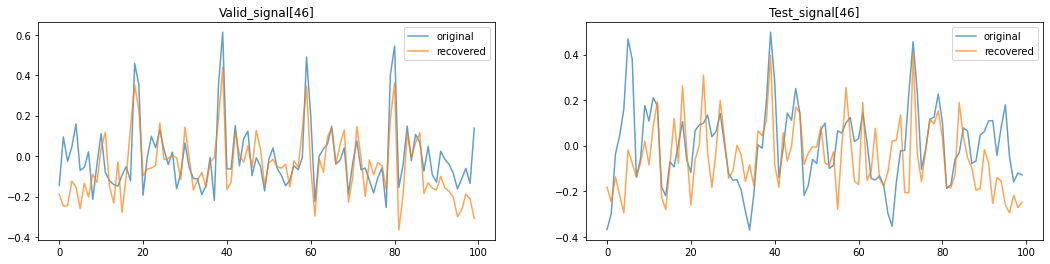

Epoch # 1: train_error = tensor(0.0013), valid_error = tensor(0.0309), test_error = tensor(0.0002)
Epoch # 2: train_error = tensor(0.0008), valid_error = tensor(0.0194), test_error = tensor(0.0002)
Epoch # 3: train_error = tensor(0.0006), valid_error = tensor(0.0150), test_error = tensor(0.0001)
Epoch # 4: train_error = tensor(0.0005), valid_error = tensor(0.0125), test_error = tensor(0.0001)
Epoch # 5: train_error = tensor(0.0004), valid_error = tensor(0.0108), test_error = tensor(0.0001)
Epoch # 6: train_error = tensor(0.0004), valid_error = tensor(0.0095), test_error = tensor(9.5315e-05)
Epoch # 7: train_error = tensor(0.0004), valid_error = tensor(0.0085), test_error = tensor(8.7073e-05)
Epoch # 8: train_error = tensor(0.0003), valid_error = tensor(0.0078), test_error = tensor(8.1094e-05)
Epoch # 9: train_error = tensor(0.0003), valid_error = tensor(0.0073), test_error = tensor(7.6135e-05)
Epoch # 10: train_error = tensor(0.0003), valid_error = tensor(0.0069), test_error = tensor(7

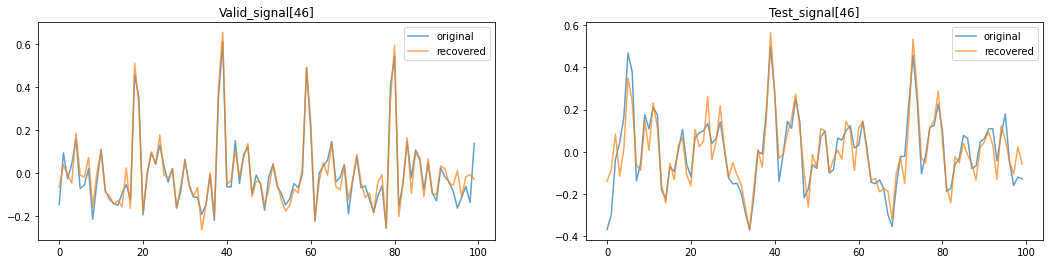

In [ ]:
AutoCNN1 = AutoCNN(x_train, y_train, x_valid, y_valid, x_test, y_test)
model, train_features, valid_features, test_features = AutoCNN1.train_test(n_epochs=50, batch_size=300, lr=0.001, show=46)

(26722, 672)
2.0


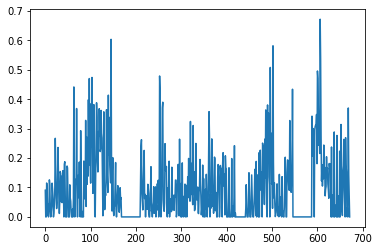

1.0


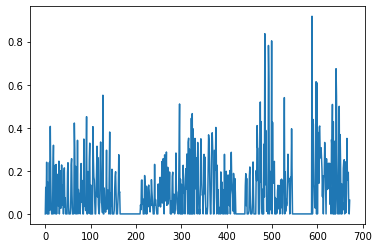

0.0


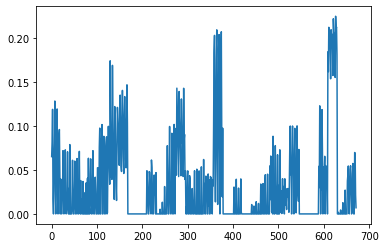

3.0


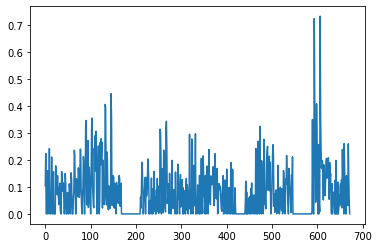

0.0


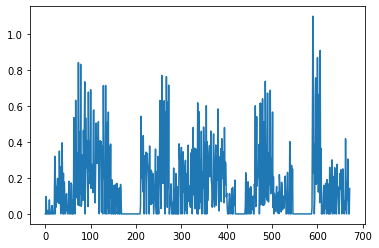

In [38]:
### check the features
print(train_features.shape)

for i in range(5):
    print(y_test[i])
    plt.plot(test_features[i]); plt.show()


accuracy of training dateset = 0.8784896340094305
accuracy of validation dateset = 0.822262118491921
accuracy of testing dateset = 0.3441358024691358
              precision    recall  f1-score   support

         0.0       0.24      0.27      0.26       325
         1.0       0.21      0.21      0.21       330
         2.0       0.62      0.41      0.50       324
         3.0       0.40      0.49      0.44       317

    accuracy                           0.34      1296
   macro avg       0.37      0.35      0.35      1296
weighted avg       0.37      0.34      0.35      1296



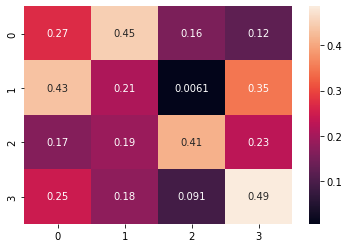

In [39]:
### SVM(rbf)
svm_model = SVC(kernel='rbf')

''' fit the model to the data'''
svm_model.fit(train_features, y_train)
y_train_pred = svm_model.predict(train_features)
print('accuracy of training dateset =', accuracy_score(y_train_pred, y_train))

y_valid_pred = svm_model.predict(valid_features)
print('accuracy of validation dateset =', accuracy_score(y_valid_pred, y_valid))

y_test_pred = svm_model.predict(test_features)
print('accuracy of testing dateset =', accuracy_score(y_test_pred, y_test))
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred, normalize= 'true')
df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
sns.heatmap(df_cm, annot=True); plt.show()


accuracy of training dateset = 0.8647182097148417
accuracy of validation dateset = 0.8078994614003591
accuracy of testing dateset = 0.36574074074074076
              precision    recall  f1-score   support

         0.0       0.34      0.40      0.37       325
         1.0       0.24      0.15      0.19       330
         2.0       0.45      0.60      0.52       324
         3.0       0.36      0.32      0.34       317

    accuracy                           0.37      1296
   macro avg       0.35      0.37      0.35      1296
weighted avg       0.35      0.37      0.35      1296



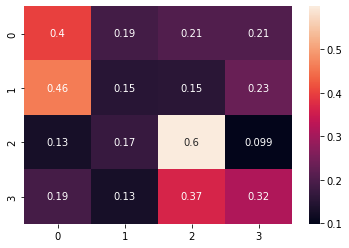

In [40]:
### SVM(poly, 3)
svm_model = SVC(kernel='poly', degree=3)

''' fit the model to the data'''
svm_model.fit(train_features, y_train)
y_train_pred = svm_model.predict(train_features)
print('accuracy of training dateset =', accuracy_score(y_train_pred, y_train))

y_valid_pred = svm_model.predict(valid_features)
print('accuracy of validation dateset =', accuracy_score(y_valid_pred, y_valid))

y_test_pred = svm_model.predict(test_features)
print('accuracy of testing dateset =', accuracy_score(y_test_pred, y_test))
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred, normalize= 'true')
df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
sns.heatmap(df_cm, annot=True); plt.show()


# **2D-DCNN**

### **Data pre-processing**

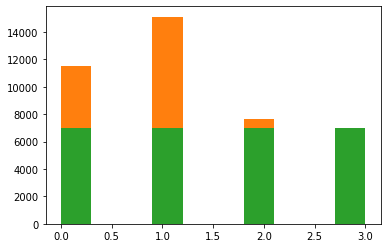

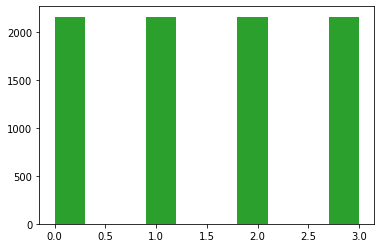

x_train.shape = (26722, 1, 100, 100) <class 'numpy.ndarray'>
x_valid.shape = (1114, 1, 100, 100) <class 'numpy.ndarray'>
x_test.shape = (1296, 1, 100, 100) <class 'numpy.ndarray'>


In [10]:
# divide data into segments
x_train, y_train = divide_signal(train_data, train_labels, window=100, moving=100, divide=120, mode='RecuPlot')
x_test, y_test = divide_signal(test_data, test_labels, window=100, moving=100, divide=120, mode='RecuPlot')

'''balance the number of each class in datasets'''
_, x_train, _, y_train = equal_shuffle_sample(x_train, y_train, n_subjects=int(np.sort(plt.hist(y_train)[0])[-len(set(y_train))])-1)
_, x_test, _, y_test = equal_shuffle_sample(x_test, y_test, n_subjects=int(np.sort(plt.hist(y_test)[0])[-len(set(y_test))])-1)

'''spliting traing data into training and validation set'''
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.04,
                                                      random_state=56)

'''randomly choos about 1000 segemnts for testing'''
_, x_test, _, y_test = train_test_split(x_test, y_test, 
                                        test_size=0.15,
                                        random_state=37)

print('x_train.shape =', x_train.shape, type(x_train))
print('x_valid.shape =', x_valid.shape, type(x_valid))
print('x_test.shape =', x_test.shape, type(x_test))

### **Model training**

In [11]:
class DCNN_2D:
    ''' 
        Inputs:        
        n_features - how many features does one sample of our data have (how many columns does the matrix have)
        hidden_dimension - the number of hidden neurons we want?
        n_classes - the number of unique labels in our data (i.e. 0,1 for the Breast Cancer dataset)
    '''
    def __init__(self, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
        self.train_data = train_data        
        self.train_labels = train_labels
        self.valid_data = valid_data
        self.valid_labels = valid_labels
        self.test_data = test_data        
        self.test_labels = test_labels

    class Net(nn.Module):
        def __init__(self, window, n_classes):
            super(DCNN_2D.Net, self).__init__()
            self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, dilation=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(kernel_size=2, stride=2),
                                       nn.Dropout(p=0.5))
            self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, dilation=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(kernel_size=2, stride=2),
                                       nn.Dropout(p=0.5))
                                       
            self.fucon = nn.Sequential(nn.Linear(in_features=16928, out_features=512), 
                                       nn.Linear(in_features=512, out_features=256),
                                       nn.Linear(in_features=256, out_features=128),
                                       nn.LeakyReLU(negative_slope=0.003),
                                       nn.Dropout(p=0.5))
            self.outpt = nn.Linear(128, n_classes)
            
        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = x.flatten(start_dim = 1)
            x = self.fucon(x)
            x = self.outpt(x)
            return nn.functional.softmax(x)

    def train_test(self, n_epochs, batch_size, lr, model=None):
        train_data_batches, train_label_batches = batchify(self.train_data, self.train_labels, batch_size=batch_size)
        
        if model == None:
            model = DCNN_2D.Net(window = 100, n_classes = 4)
        else:
            model = model

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.CrossEntropyLoss()
        
        for i in range(n_epochs):
            model.train()
            train_correct = 0
            for ii in range(len(train_data_batches)):
                optimizer.zero_grad()
                batch = train_data_batches[ii]
                labels = train_label_batches[ii]
                predictions = model(torch.tensor(batch.astype(np.float32)))
                loss = loss_function(predictions, torch.LongTensor(labels))

                loss.backward()
                optimizer.step() 
                for n, pred in enumerate(predictions.data):
                    if labels[n] == torch.argmax(pred):
                        train_correct += 1
            print("Epoch # " + str(i) + ": train_acc =" + str(round(train_correct/len(self.train_data), 4)), end=', ')

            model.eval()
            valid_correct = 0
            predictions = model(torch.tensor(self.valid_data.astype(np.float32)))     
            for n, pred in enumerate(predictions.data):
                if self.valid_labels[n] == torch.argmax(pred):
                        valid_correct += 1       
            print("valid_acc =" + str(round(valid_correct/len(self.valid_data), 4)), end=', ')
            
            model.eval()
            test_correct = 0
            test_predict = np.zeros((len(self.test_labels)))
            predictions = model(torch.tensor(self.test_data.astype(np.float32)))
            for n, pred in enumerate(predictions.data):
                if self.test_labels[n] == torch.argmax(pred):
                    test_correct += 1
                test_predict[n] = torch.argmax(pred)       
            print("test_acc = " + str(round(test_correct/len(self.test_data), 4)))

        print(classification_report(self.test_labels, test_predict))
        cm = confusion_matrix(self.test_labels, test_predict, normalize= 'true')
        df_cm = pd.DataFrame(cm, index=[0,1,2,3], columns=[0,1,2,3])
        sns.heatmap(df_cm, annot=True); plt.show()
        return model

def batchify(data,labels,batch_size=16):
    batches= []
    label_batches = []
    for n in range(0,len(data),batch_size):
        if n+batch_size < len(data):
            batches.append(data[n:n+batch_size])
            label_batches.append(labels[n:n+batch_size])
    if len(data)%batch_size > 0:
        batches.append(data[len(data)-(len(data)%batch_size):len(data)])
        label_batches.append(labels[len(data)-(len(data)%batch_size):len(data)])
    return batches,label_batches


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch # 0: train_acc =0.2511, valid_acc =0.2487, test_acc = 0.25
Epoch # 1: train_acc =0.2506, valid_acc =0.2487, test_acc = 0.25
Epoch # 2: train_acc =0.2489, valid_acc =0.2487, test_acc = 0.25
Epoch # 3: train_acc =0.2503, valid_acc =0.2487, test_acc = 0.25
Epoch # 4: train_acc =0.2499, valid_acc =0.2487, test_acc = 0.25
Epoch # 5: train_acc =0.2488, valid_acc =0.2487, test_acc = 0.25
Epoch # 6: train_acc =0.2495, valid_acc =0.2487, test_acc = 0.25
Epoch # 7: train_acc =0.2499, valid_acc =0.2487, test_acc = 0.25
Epoch # 8: train_acc =0.2495, valid_acc =0.2487, test_acc = 0.25
Epoch # 9: train_acc =0.2503, valid_acc =0.2487, test_acc = 0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       325
         1.0       0.00      0.00      0.00       330
         2.0       0.25      1.00      0.40       324
         3.0       0.00      0.00      0.00       317

    accuracy                           0.25      1296
   macro avg       0.06 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


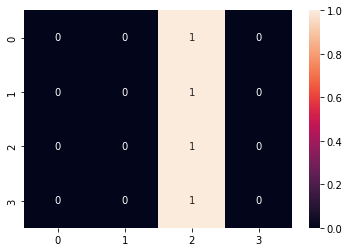

In [13]:
DCNN2 = DCNN_2D(x_train, y_train, x_valid, y_valid, x_test, y_test)
model = DCNN2.train_test(n_epochs=10, batch_size=500, lr=0.01)